<a href="https://colab.research.google.com/github/IHMilon/vision-model-comparison/blob/main/1.%20ViT_EuroSAT/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🌍Vision Transformer (ViT) from Scratch on EuroSAT**

I built a **lightweight Vision Transformer (ViT)** from scratch and trained it on the **EuroSAT RGB dataset** to classify different land-use types.  
This project highlights how I implemented **patch embeddings** and designed an **efficient transformer**, all while working with limited computing resources.

## **Dataset Gathering**
The **EuroSAT** dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset), a widely recognized platform for open-access datasets.

In [ ]:
# Create .kaggle dir for API key file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download the zip data file
!kaggle datasets download -d apollo2506/eurosat-dataset 1>/dev/null

In [ ]:
# Unzip the dataset
!unzip /content/eurosat-dataset.zip -d datasets/ 1>/dev/null

## **Install Required Packages**

In [ ]:
!pip install torchprofile 1>/dev/null
!pip install split-folders 1>/dev/null

## **Import Required Libraries**

In [ ]:
import os
import time
import math
import random
import warnings
import numpy as np
import splitfolders
from PIL import Image
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast, GradScaler

## **Reproducibility**

In [ ]:
torch.manual_seed(29)
random.seed(29)
np.random.seed(29)
torch.cuda.manual_seed(29)

## **Set the Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is: {device}")

Device is: cuda


## **Inspecting and Cleaning the Dataset**

Before training, it's important to make sure the dataset is complete and free from any broken or missing samples.  
This step ensures the model learns from clean, high-quality data during both training and testing.

In [ ]:
# Dataset path
data_path = "/content/datasets/EuroSAT"

In [ ]:
# Check num_samples and remove corrupt images.
def inspect(data_dir):
    removed_files = 0
    total_img = 0
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            path = os.path.join(root, file)
            if file.endswith(('.csv','.json')):
                os.remove(path)
                continue
            else:
                try:
                    img = Image.open(path)
                    total_img += 1
                    img.verify()
                except Exception as e:
                    os.remove(path)
                    removed_files += 1
    return total_img, removed_files

total_img, removed_img = inspect(data_path)
print(f"Total samples: {total_img}\nRemoved samples: {removed_img}")

Total samples: 27000
Removed samples: 0


In [ ]:
# Check all samples shape
shapes = []
for root, dir, files in os.walk(data_path):
    for file in files:
        if file.lower().endswith(('.jpg','.jpeg','.png')):
            path = os.path.join(root, file)
            image = Image.open(path)
            shapes.append((image.size[1], image.size[0], len(image.getbands())))
unique_shapes = set(shapes)
print(f"All image shapes: {unique_shapes}")

All image shapes: {(64, 64, 3)}


In [ ]:
# Samples per class
print("Samples per Class:\n")
for i, folder in enumerate (os.listdir(data_path)):
    folder_path = os.path.join(data_path, folder)
    print(f"{i+1}. {folder}: {len(os.listdir(folder_path))}")

Samples per Class:

1. Residential: 3000
2. River: 2500
3. AnnualCrop: 3000
4. SeaLake: 3000
5. Industrial: 2500
6. HerbaceousVegetation: 3000
7. Highway: 2500
8. Pasture: 2000
9. PermanentCrop: 2500
10. Forest: 3000


## **Split the Dataset**
The dataset was split into 80% training and 20% validation sets.

In [ ]:
# Folder Path
input_folder = "/content/datasets/EuroSAT"
output_folder = "/content/splited"
# Train 80% and Val 20%
split_ratio = (0.8, 0.2)
seed = 29

# Split the folder to train and val set
splitfolders.ratio(
      input = input_folder,
      output = output_folder,
      ratio = split_ratio,
      seed = seed
      )

### **Samples per Class After Splitting**

Here’s how the dataset is distributed across all classes after the train-test split.

In [ ]:
split_folder = ["train","val"]
print("Class distribution after splitting:")
for folder in split_folder:
    print(f"\n{folder.upper()} FOLDER")
    print("_"*20)
    path = os.path.join(output_folder,folder)
    for dir in os.listdir(path):
        class_path = os.path.join(path,dir)
        files = len(os.listdir(class_path))
        print(f"--> {dir}: {files}")

Class distribution after splitting:

TRAIN FOLDER
____________________
--> Residential: 2400
--> River: 2000
--> AnnualCrop: 2400
--> SeaLake: 2400
--> Industrial: 2000
--> HerbaceousVegetation: 2400
--> Highway: 2000
--> Pasture: 1600
--> PermanentCrop: 2000
--> Forest: 2400

VAL FOLDER
____________________
--> Residential: 600
--> River: 500
--> AnnualCrop: 600
--> SeaLake: 600
--> Industrial: 500
--> HerbaceousVegetation: 600
--> Highway: 500
--> Pasture: 400
--> PermanentCrop: 500
--> Forest: 600


## **Custom Dataset Class**

I created a custom dataset class by extending PyTorch’s `Dataset` class to efficiently load images and apply the necessary transformations on the fly.

In [ ]:
# Custom Dataset Class
class EuroSAT(Dataset):
    def __init__(self, root, transforms = None):
        self.transforms = transforms
        self.img_paths = []
        self.labels = []

        # Convert class name to label index
        self.classes = sorted(os.listdir(root))
        self.class2idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Store all the image paths and labels to the defined list
        for folder in os.listdir(root):
           folder_path = os.path.join(root,folder)
           for file in os.listdir(folder_path):
               file_path = os.path.join(folder_path,file)
               self.img_paths.append(file_path)
               self.labels.append(self.class2idx[folder])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Collect image at the index
        image = self.img_paths[idx]
        image = Image.open(image).convert("RGB") # Ensure image is in RGB format
        label = self.labels[idx]

        if self.transforms:
            # Apply transforms to image
            image = self.transforms(image)

        return image, label

## **Data Augmentation**

I applied several data augmentation techniques to expand the dataset and help the model learn more general patterns, improving its overall performance.

In [ ]:
# Data augmentation on training set
train_transforms = transforms.Compose([
     transforms.RandomCrop(64, padding = 5),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ColorJitter(brightness = 0.3,
                contrast = 0.2,
                saturation = 0.3,
                hue = 0.2),
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
     ])

# Test set is only converted to Tensor and Normalized
test_transforms = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
              ])

## **Batch Preparation**

To ensure each batch contains a balanced mix of classes and loads efficiently, I created a custom DataLoader for the dataset.

In [ ]:
train_path = "/content/splited/train"
train_dataset = EuroSAT(train_path, transforms = train_transforms)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory = True)

val_path = "/content/splited/val"
val_dataset = EuroSAT(val_path, transforms = test_transforms)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = False, pin_memory = True)

## **Visualization of Batch Images**

Here, I visualized a few sample batches to check that the transformations were applied correctly and the images were loading as expected.

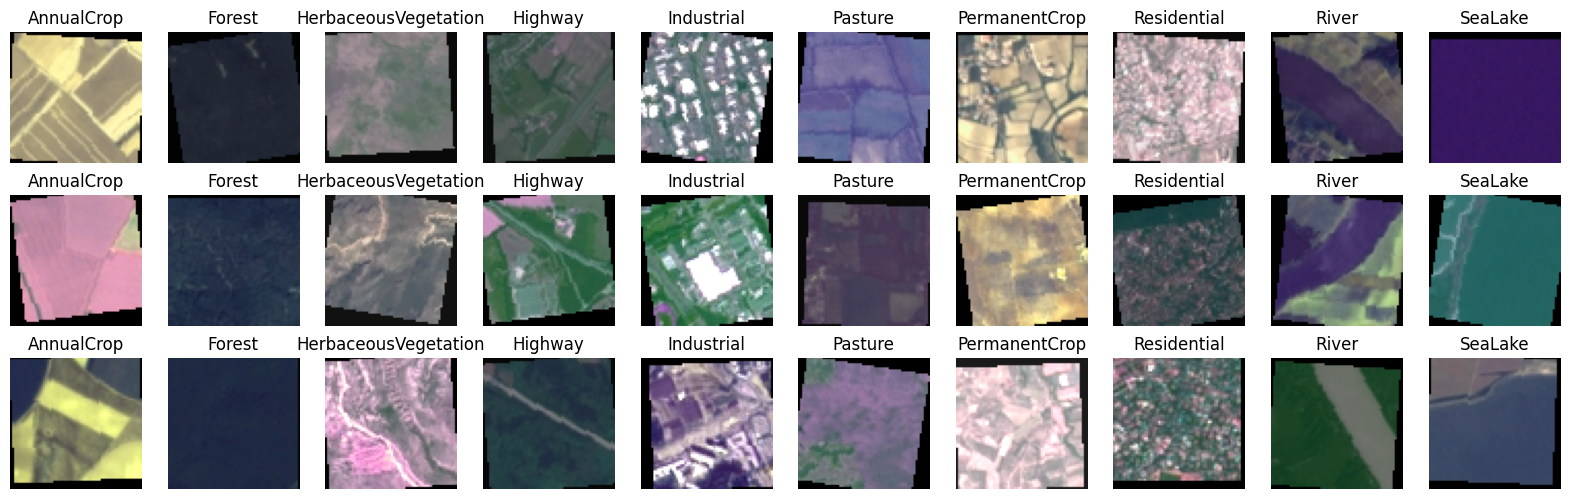

In [ ]:
# Collect 3 samples from each class
samples = [[] for _ in range(10)]
# Iterate through the validation dataset directly to get individual images and labels
for image, label in train_dataset:
    if len(samples[label]) < 3:
        samples[label].append(image)

# Visualize the collected images
plt.figure(figsize = (20, 6))
for idx in range(30):
    label = idx % 10
    image = samples[label][idx//10]

    # Covert shape CHW to HWC for Vis.
    image = image.permute(1,2,0)

    # Convert mean and std to tensor
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    # Denormalize the image tensor
    image = image*std+mean

    # Convert label idx to name
    label = train_dataset.classes[label]

    # Create subplot for vis.
    plt.subplot(3, 10, 1+idx)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.show()

## **Batch Size Inspection**

I checked the batch shapes to make sure the data was loaded correctly and organized properly before feeding it into the model.

In [ ]:
for images, labels in train_loader:
    print(f"Images Shapes: {images.shape}")
    print(f"Labels shapes: {labels.shape}")
    break

Images Shapes: torch.Size([128, 3, 64, 64])
Labels shapes: torch.Size([128])


## **Defining the Vision Transformer Model**

I built the ViT completely from scratch using PyTorch.  
All key components including **self-attention** for learning relationships between image patches and **multi-head attention** for richer feature representation were implemented manually.  

The model creates **patch embeddings**, adds **learnable positional encodings** and a **class token**, and passes them through multiple **encoder blocks** followed by MLP layers.  
Finally, the **class token output** is used by the **prediction head** to generate the final classification.  

I used PyTorch’s `Linear` layers for initialization since they apply **He initialization** by default this helped avoid instability issues I noticed with random initialization.

In [ ]:
# SelfAttention Block
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim, key_dim):
        super().__init__()
        self.embedding = embedding_dim
        self.key = key_dim
        self.wq = nn.Linear(embedding_dim, key_dim)
        self.wk = nn.Linear(embedding_dim, key_dim)
        self.wv = nn.Linear(embedding_dim, key_dim)

    def forward(self, x):
        Q = self.wq(x) # (B, E, head_dim)
        K = self.wk(x) # (B, E, head_dim)
        V = self.wv(x) # (B, E, head_dim)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))  # (B, E, E)
        scores = scores / math.sqrt(self.key) # scale for softmax
        attn = F.softmax(scores, dim = -1)
        out = torch.matmul(attn, V)  # (B, E, head_dim)
        return out

# Multi Head Attention Block
class MHA(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.embedding = embedding_dim
        self.heads = num_heads
        # Embedding dim must be divisible by #heads
        assert embedding_dim % num_heads == 0
        # Calculate the key_dim
        self.key_dim = embedding_dim//num_heads
        # Multihead Attention consist of multiple SelfAttention
        self.mha = nn.ModuleList([
                   SelfAttention(embedding_dim, self.key_dim)
                   for _ in range(num_heads)])

        # Define the Projection matrix
        self.proj = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        # Pass the data to all the self attention
        out = [attention(x) for attention in self.mha]
        # Concatenate all the output of SelfAttention
        out = torch.cat(out, -1)
        # Project the concatenated matrix
        out = self.proj(out)
        return out


# MLP layer
class MLP(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout = 0.1):
        super().__init__()
        self.mlp = nn.Sequential(
             nn.Linear(embedding_dim, hidden_dim),
             nn.GELU(),
             nn.Dropout(dropout),
             nn.Linear(hidden_dim, embedding_dim),
             nn.Dropout(dropout)
             )

    def forward(self, x):
        # adds non linearity
        out = self.mlp(x)
        return out


# Transformer Encoder Block
class Encoder(nn.Module):
    def __init__(self, embedding_dim = 512, num_heads = 8, hidden_dim = 1024, dropout = 0.1):
        super().__init__()
        self.mha = MHA(embedding_dim, num_heads)
        self.mlp = MLP(embedding_dim, hidden_dim, dropout)
        # Layer norm helps to normalize the values which helps training
        self.layernorm1 = nn.LayerNorm(embedding_dim)
        self.layernorm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        skip = x
        out = self.layernorm1(x)
        out = self.mha(out)
        out = self.dropout(out)
        residual = out + skip
        out = self.layernorm2(residual)
        out = self.mlp(out)
        out = self.dropout(out)
        residual = out + residual
        return residual

# Prediction Head
class PredHead(nn.Module):
    def __init__(self, embedding_dim, num_classes, dropout = 0.1):
        super().__init__()
        # Modified as data has 10 classes only
        self.predhead = nn.Sequential(
             nn.LayerNorm(embedding_dim),
             nn.Linear(embedding_dim, num_classes),
             )
    def forward(self, x):
        out = self.predhead(x)
        return out

In [ ]:
# Vision Transformer Model
class ViT(nn.Module):
    def __init__(self, patch_size = 8, image_size = 64, channel = 3, embedding_dim = 512, hidden_dim = 1024, num_heads = 8, num_layers = 12, num_classes = 10, dropout = 0.1):
        super().__init__()
        self.patch = patch_size
        self.channel = channel
        self.embedding = embedding_dim
        # Calculate the #patch
        self.num_patch = int((image_size**2)/(patch_size**2))

        # Embeddings matrix
        self.emb = nn.Linear(channel*patch_size**2, embedding_dim)
        # Class token
        self.cls = nn.Parameter(torch.rand(1, 1, embedding_dim))
        # Positional information
        self.pos = nn.Parameter(torch.rand(1, self.num_patch+1, embedding_dim))

        # Instantiate the Encoder Block
        encoder_dim = [Encoder(embedding_dim, num_heads, hidden_dim, dropout)
                       for _ in range(num_layers)]
        self.encoder = nn.Sequential(*encoder_dim)
        # Prediction Head
        self.pred = PredHead(embedding_dim, num_classes, dropout)

    def forward(self, x):
        p, c = self.patch, self.channel
        # Split images into patches
        patches = x.unfold(2, p, p).unfold(3, p, p) # x shape (B, C, H, W), patches shape (B, C, H/p, W/p, p, p)
        # Reshape the patches shape to (B, num_patches, C*p*p)
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous() # (B, H/p, W/p, C, p, p)
        patches = patches.view(patches.size(0), self.num_patch, c*p*p).float() # (B, num_patches, C*p*p)
        # Create the patch embeddings
        patch_emb = self.emb(patches) # (B, num_patches, embedding_dim)

        # Concatenate the class token
        batch = patch_emb.size(0)
        patch_emb = torch.cat([self.cls.repeat(batch,1,1), patch_emb], 1) # (B, num_patches+1, embedding_dim)

        # Add the positional information
        patch_emb = patch_emb + self.pos

        # Pass it to the encoder layers
        out = self.encoder(patch_emb) # (B, num_patches+1, embedding_dim)
        # Extract the class token
        cls_token = out[:,0] # (B, embedding_dim)
        # Pass to the prediction head for classification
        pred = self.pred(cls_token) # (B, num_classes)
        return pred

### **Instantiate the Model and Move to GPU**

In [ ]:
model = ViT(patch_size = 8, image_size = 64, channel = 3, embedding_dim = 160, hidden_dim = 640, num_heads = 5, num_layers = 10, num_classes = 10, dropout = 0.1)
model = model.to(device)

## **Model Size**

The total number of trainable parameters gives an idea of the model’s size and complexity.

In [ ]:
num_params = 0
for params in model.parameters():
    if params.requires_grad:
        num_params += params.numel()
print(f"Total Parameters: {(num_params/10**6):.1f} Million")

Total Parameters: 3.1 Million


## **Computation Cost**

The computational cost of a model shows how much work is required to make a prediction.  
A common way to measure this is using **Multiply–Accumulate Operations (MACs)**, which counts the total computations performed during inference.

In [ ]:
# To clear unwanted massages
warnings.filterwarnings("ignore")

# Dummy samples
x = torch.ones(1, 3, 64, 64).to(device)
macs = profile_macs(model, x)
print(f"Total MACs: {(macs/10**6):.2f} Million")

Total MACs: 215.38 Million


## **Training Configuration**

The model was trained using `CrossEntropyLoss` with the `AdamW` optimizer and weight decay for regularization.

Here Mixed precision doesn't helps the model's as it is very sensitive. I tried but the performance didn't improve.

In [ ]:
# Number of training epochs
epochs = 50

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 3e-4, weight_decay = 0.0001)

### **Function to Calculate Top-K Accuracy**
Evaluating only top-1 accuracy may not fully capture the model’s predictive capability, especially when multiple classes share similar visual patterns.

In [ ]:
def top_k_accuracy(outputs, labels, k = 3):
    # Stop gradient tracking
    with torch.no_grad():
        # returns Top-K logit's index
        _, preds = torch.topk(outputs, k, dim = 1)
        # check tru labels among topk
        correct = preds.eq(labels.unsqueeze(1).expand_as(preds))
        # calculate accuracy
        acc = correct.any(dim = 1).float().mean().item()
    return acc

### **Training Function (One Epoch)**

This function handles the training of the model for a single epoch, including forward pass, loss computation, and backpropagation.

In [ ]:
def train(model, train_loader, criterion, optimizer, device):

    # Set to training mode
    model.train()
    running_loss, batch = 0, 0
    acc1, acc2 = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate gradients and update weights
        loss.backward()
        optimizer.step()

        # Accuracy Calculation
        top1 = top_k_accuracy(outputs, labels, k = 1)
        top2 = top_k_accuracy(outputs, labels, k = 2)

        # metrics tracking
        running_loss += loss.item()
        acc1 += top1
        acc2 += top2
        batch += 1

    loss = running_loss/batch
    top1_acc = acc1/batch
    top2_acc = acc2/batch

    return loss, top1_acc, top2_acc

### **Evaluation Function (One Epoch)**

This function evaluates the model on the validation set for a single epoch, computing the loss and accuracy to track performance.

In [ ]:
def evaluate(model, test_loader, criterion, device):

    # Set to evaluation mode
    model.eval()
    running_loss, batch = 0, 0
    acc1, acc2 = 0, 0

    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            top1 = top_k_accuracy(outputs, labels, k = 1)
            top2 = top_k_accuracy(outputs, labels, k = 2)

            # track test metrices
            running_loss += loss.item()
            acc1 += top1
            acc2 += top2
            batch += 1

        # Calculate final metrics
        loss = running_loss/batch
        top1_acc = acc1/batch
        top2_acc = acc2/batch

    return loss, top1_acc, top2_acc

### **Training Loop**

The model is trained over multiple epochs, updating weights with the optimizer and tracking **loss** and **accuracy** on both training and validation sets to monitor learning progress.

In [ ]:
# Store the acc & loss for each epoch
train_losses, train_accs = [], []
test_losses, test_accs =[], []

# Start time
start_time = time.time()

# Train the model
for i in range(1, epochs+1):
    # Train and validation function
    train_loss, train_acc1, train_acc2 = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc1, test_acc2 = evaluate(model, val_loader, criterion, device)

    # Store the loss and top1 accuracys
    train_losses.append(train_loss)
    train_accs.append(train_acc1)
    test_losses.append(test_loss)
    test_accs.append(test_acc1)

    # Printing accs after every 5 epochs
    if i % 5 == 0:
        print(f"{i}. Train --> Top1_acc: {(train_acc1*100):.2f}% | Top2_acc: {(train_acc2*100):.2f}%")
        print(f"{i}. Test  --> Top1_acc: {(test_acc1*100):.2f}% | Top2_acc: {(test_acc2*100):.2f}%")
        print("-"*50)

# Calculate the Training Time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal time to train the model is {(total_time/60):.2f} Minutes")

5. Train --> Top1_acc: 61.46% | Top2_acc: 81.91%
5. Test  --> Top1_acc: 67.84% | Top2_acc: 85.97%
--------------------------------------------------
10. Train --> Top1_acc: 70.39% | Top2_acc: 87.54%
10. Test  --> Top1_acc: 77.06% | Top2_acc: 91.06%
--------------------------------------------------
15. Train --> Top1_acc: 76.74% | Top2_acc: 91.21%
15. Test  --> Top1_acc: 81.23% | Top2_acc: 92.53%
--------------------------------------------------
20. Train --> Top1_acc: 80.42% | Top2_acc: 93.01%
20. Test  --> Top1_acc: 85.23% | Top2_acc: 94.97%
--------------------------------------------------
25. Train --> Top1_acc: 82.31% | Top2_acc: 94.19%
25. Test  --> Top1_acc: 87.14% | Top2_acc: 96.26%
--------------------------------------------------
30. Train --> Top1_acc: 83.96% | Top2_acc: 95.07%
30. Test  --> Top1_acc: 87.56% | Top2_acc: 96.37%
--------------------------------------------------
35. Train --> Top1_acc: 85.02% | Top2_acc: 95.64%
35. Test  --> Top1_acc: 88.37% | Top2_acc: 96.

## **Loss & Accuracy Plot**

Visualizing the training and validation **loss** and **accuracy** helps understand the model’s learning behavior and identify any signs of overfitting.

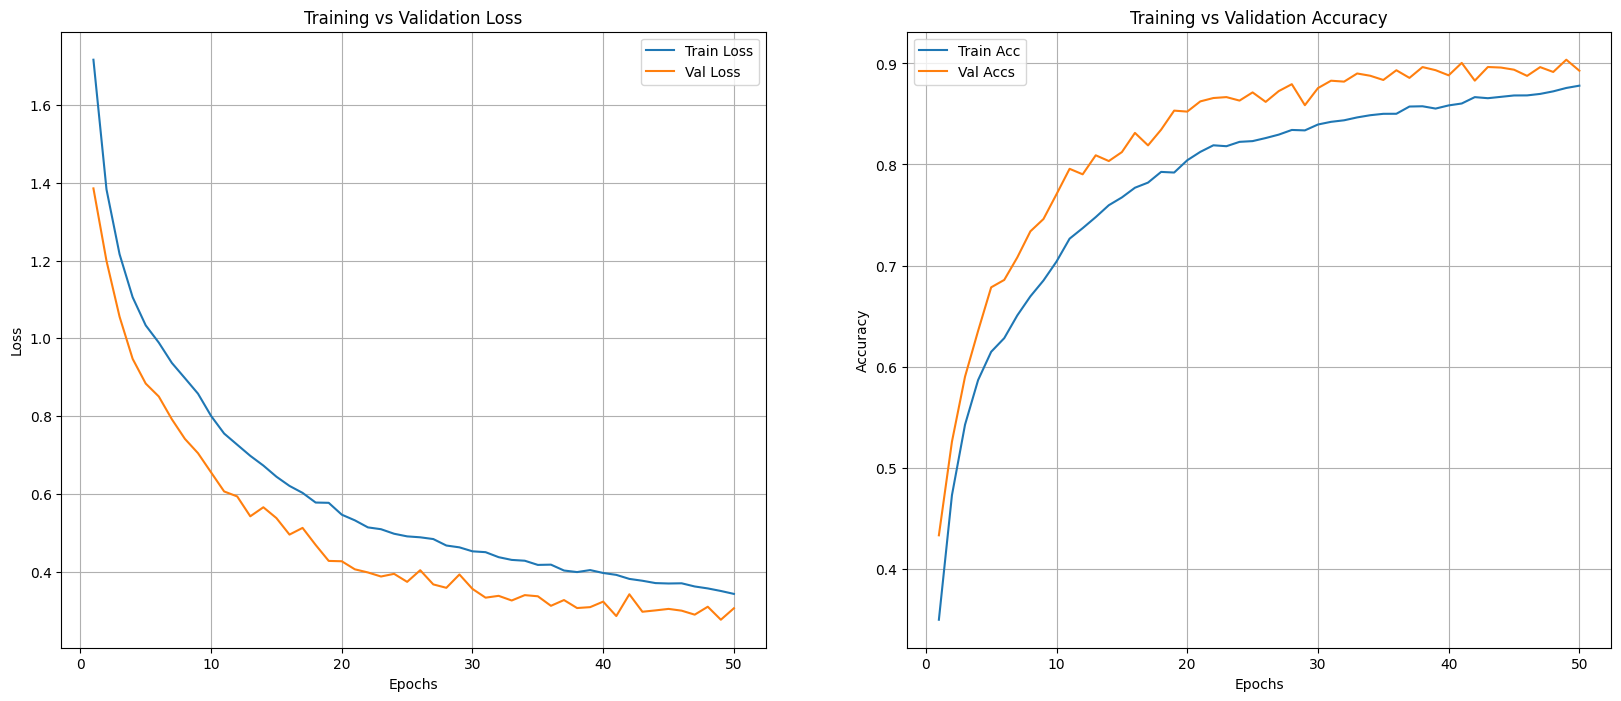

In [ ]:
epoch_range = range(1,51)
plt.figure(figsize=(20,8))

# Plot the Train and Val loss
plt.subplot(1,2,1)
plt.plot(epoch_range, train_losses, label = "Train Loss")
plt.plot(epoch_range, test_losses, label = "Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot the Train and Val Accuracy
plt.subplot(1,2,2)
plt.plot(epoch_range, train_accs, label = "Train Acc")
plt.plot(epoch_range, test_accs, label = "Val Accs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()

## **Prediction Visualization**

I visualized the model’s predictions on the test set to see how well it performs across different classes.

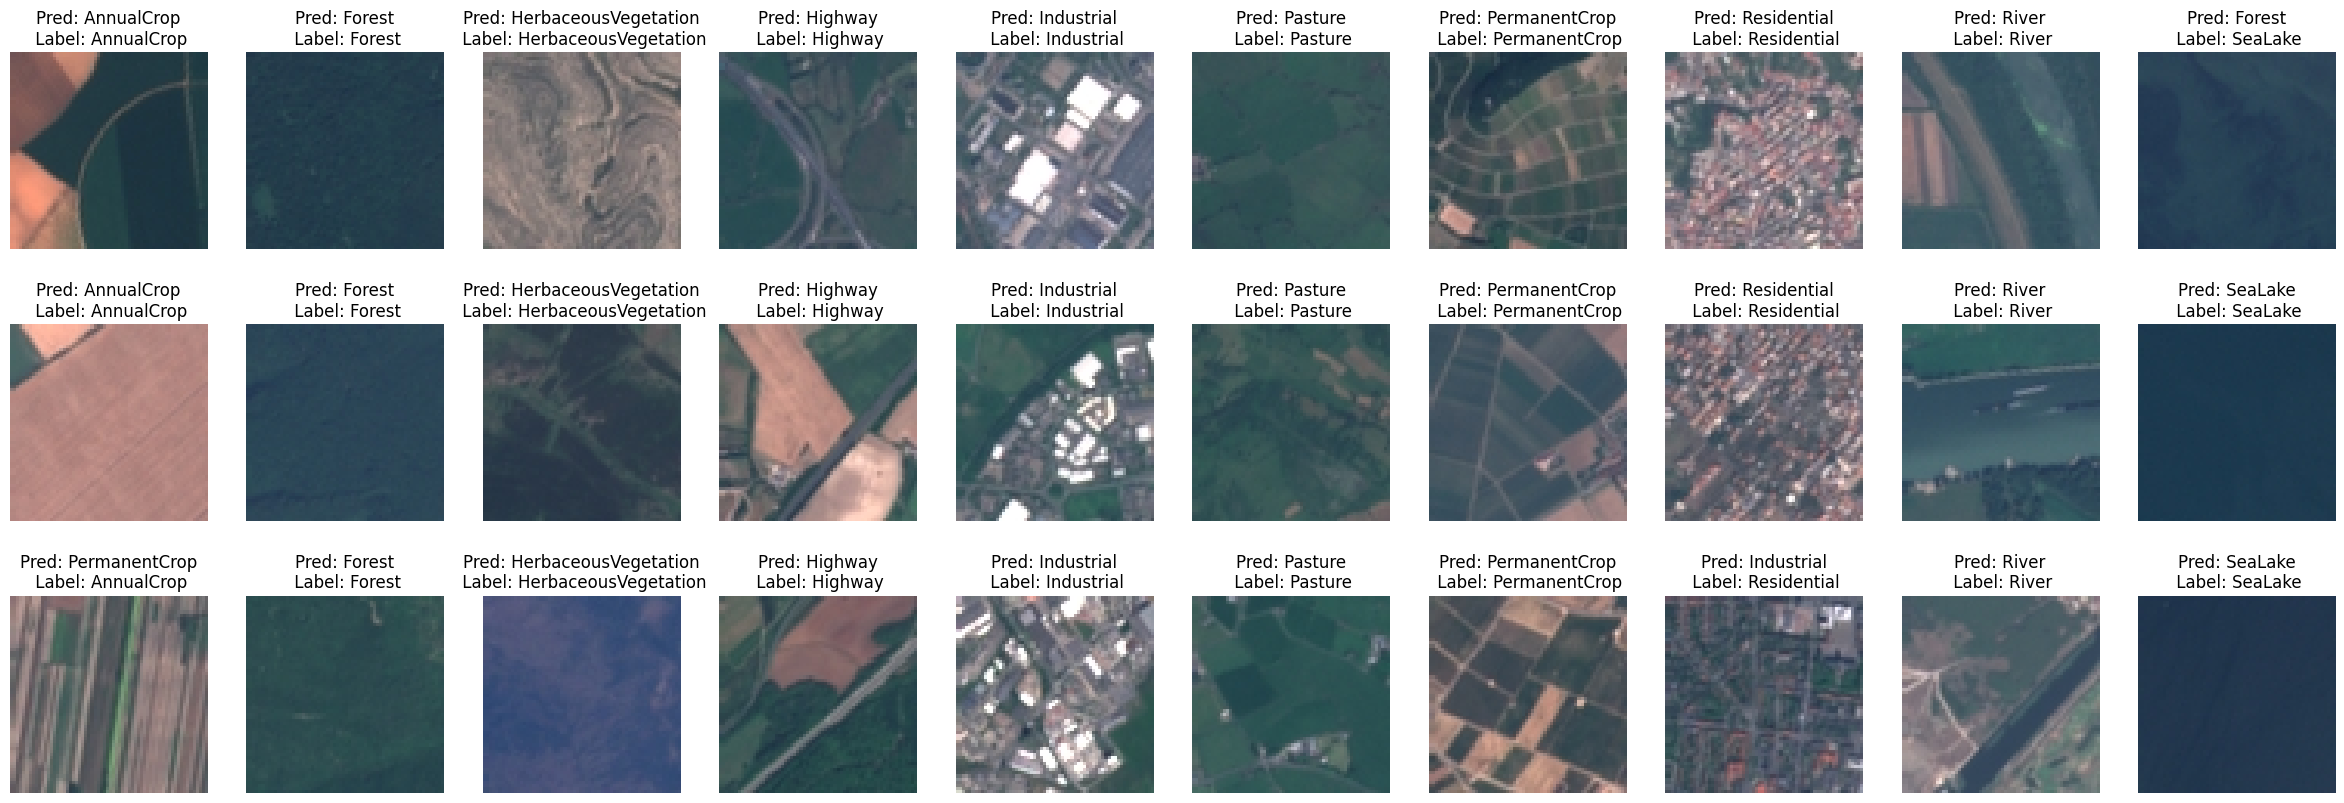

In [ ]:
# Collect 3 samples from each class
samples = [[] for _ in range(10)]
# Iterate through the validation dataset
for image, label in val_dataset:
    if len(samples[label]) < 3:
        samples[label].append(image)

# Prediction and visualization
plt.figure(figsize=(30,10))
for idx in range(30):
    label_idx = idx % 10
    image = samples[label_idx][idx//10]

    # Predict the class
    model.eval()
    with torch.inference_mode():
         pred = model(image.unsqueeze(dim=0).to(device))
         pred = pred.argmax(dim = 1).item()

    # Covert shape CHW to HWC for Vis.
    image = image.permute(1,2,0)
    # Denormalize with the same mean and std for visualization
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    image = image*std+mean
    # Convert label idx to name
    true_label = val_dataset.classes[label_idx]
    pred_label = val_dataset.classes[pred]

    # Create subplot for vis.
    plt.subplot(3, 10, 1+idx)
    plt.imshow(image)
    plt.title(f"Pred: {pred_label}"+ "\n" + f" Label: {true_label}")
    plt.axis('off')
plt.show()

## **Confusion Matrix**

The confusion matrix shows how well the model predicts each class on the test set and highlights which classes are most often misclassified.

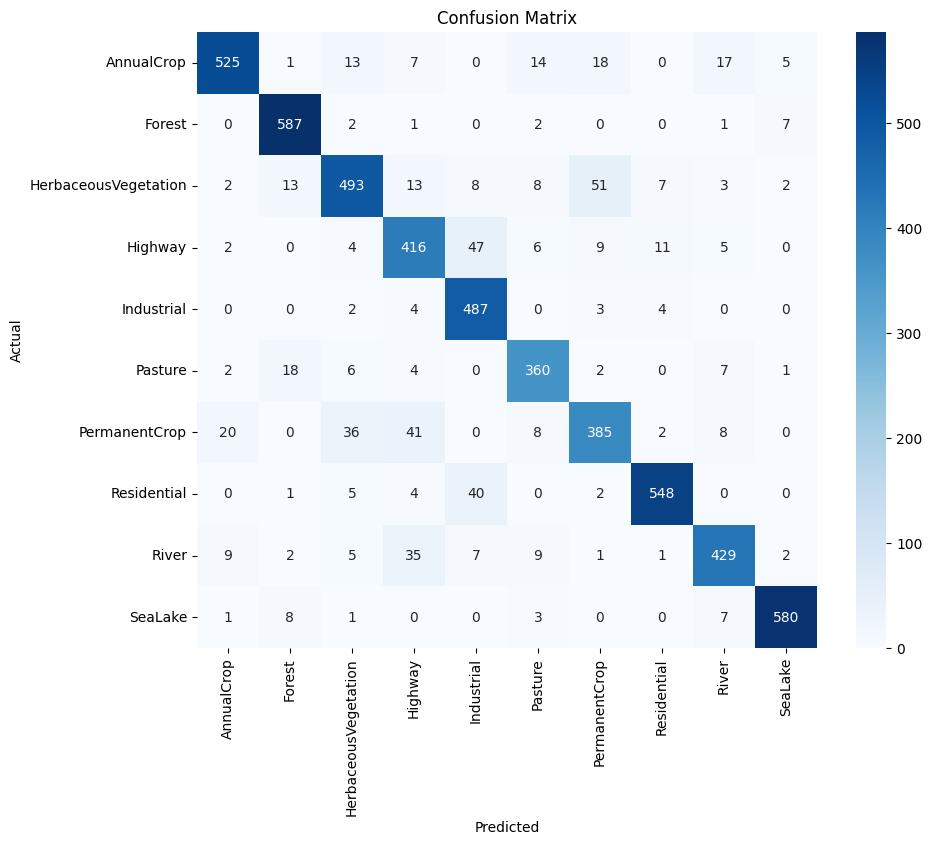

In [ ]:
# Collect predictions and true labels
true_labels = []
predictions = []

model.eval()
with torch.inference_mode():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1)
        # store the true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(pred.cpu().numpy())

# Compute confusion matrix
matrix = confusion_matrix(true_labels, predictions)

# Get class name from label index
class_name = val_dataset.classes

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_name, yticklabels=class_name, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Latency and Throughput**

We evaluate the model’s performance by measuring **inference time (latency)** and **samples processed per second (throughput)**, giving insights into its efficiency in real-world scenarios.

In [ ]:
# Dummy samples for latency and throughput
dummy = torch.ones(128, 3, 64, 64).to(device)

model.eval()
# Stop CPU to execute code before the GPU finished
torch.cuda.synchronize() if device == 'cuda' else None
start = time.time()

with torch.inference_mode():
    _ = model(dummy)

torch.cuda.synchronize() if device == 'cuda' else None
end = time.time()

total_time = end - start
throughput = 128 / total_time

print(f"Time per batch: {total_time*1000:.2f} ms")
print(f"Throughput: {throughput:.2f} images/sec")

Time per batch: 12.09 ms
Throughput: 10590.63 images/sec
